In [1]:
import os
import numpy as np
from skimage import color as skcolor
from skimage import io as skio
import matplotlib.pyplot as plt
from scipy.misc import imresize
from __future__ import print_function
# from matplotlib import *
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
%matplotlib inline

In [2]:
def load_raw_images(folder_path, check_dims=True):
    images = []

    for image_path in os.listdir(folder_path):
#         try:
        image = skio.imread(os.path.join(folder_path, image_path))
        images.append(image)
#         except Exception:
#             print("{} cannot be opened".format(image_path))

    if check_dims:
        assert all((image.shape == images[0].shape for image in images)), "images do not have equal dimensions"
    
    return images

def convert_to_binary(images):
    grays = [skcolor.rgb2gray(image) for image in images]
    binarys = []

    for image in grays:
        binary = image.copy().astype(np.uint8)
        binary[image <= 0.5] = 1
        binary[image > 0.5] = 0
        binarys.append(binary)

    return binarys

def resize_images(images, size):
    return [imresize(image, size) for image in images]
 

(1080, 1920, 3)
(32, 32, 3)
(32, 32)


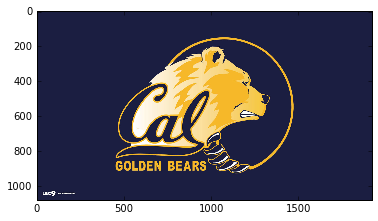

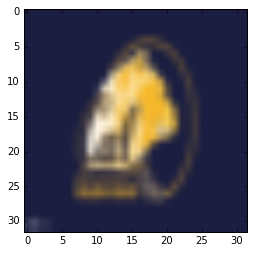

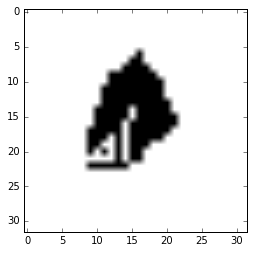

In [3]:
raws = load_raw_images('test_layers')

print(raws[0].shape)
plt.figure()
plt.imshow(raws[0])

size = (32, 32)

resizes = resize_images(raws, size)
print(resizes[0].shape)
plt.figure()
plt.imshow(resizes[0], cmap=plt.get_cmap('gray'))

binarys = convert_to_binary(resizes)

print(binarys[0].shape)
plt.figure()
plt.imshow(binarys[0], cmap=plt.get_cmap('gray'))


In [4]:
class GCommand(object):
    def __init__(self, x, y, z, material, wait=100):
        self.x = x
        self.y = y
        self.z = z
        self.material = material
        self.wait = wait
    # WHAT. This is just the same thing.
    def __str__(self):
        if self.material == 0.0:
            return "G1 X{} Y{} ;material {}\nM106 ;fan on\nG4 P{}\nM107 ;fan off"\
            .format(self.x, self.y, self.material, self.wait)
        else:
            return "G1 X{} Y{} ;material {}\nM106 ;fan on\nG4 P{}\nM107 ;fan off"\
            .format(self.x, self.y, self.material, self.wait)
# so we have pattern/path but not yet droplets?
def convert_to_gcode(binary_layers, grid_unit=0.5, start_x=40, start_y=50, flip_flop=True):
    gcommands = []
    num_layers = len(binary_layers)
    for i in range(num_layers):
        for grid_y in range(binary_layers[i].shape[0]):
            if grid_y % 2 == 0 and flip_flop:
                x_iterator = reversed(range(binary_layers[i].shape[0]))
            else:
                x_iterator = range(binary_layers[i].shape[0])
            for grid_x in x_iterator:
                gcommand = GCommand(grid_x * grid_unit + start_x, \
                                    grid_y * grid_unit + start_y, \
                                    i*grid_unit, \
                                    binary_layers[i][grid_y, grid_x])
                gcommands.append(gcommand)

    return gcommands

def write_gcode(gcommands, gcode_path, 
                start_gcode='G21 ;metric values\nG90 ;absolute positioning\nG28 X0 Y0 ;move X/Y to min endstops\nM104 S0 ;extruder heater off\nM140 S0 ;heated bed heater off (if you have it)\n;Put printing message on LCD screen\nM117 Printing...', \
                end_gcode='M84 ;steppers off\n;done printing'):
    with open(gcode_path, 'w') as gcode_file:
        gcode_file.write(start_gcode)
        gcode_file.write('\n')
        
        for gcommand in gcommands:
            gcode_file.write(str(gcommand))
            gcode_file.write('\n')
        
        gcode_file.write(end_gcode)
        gcode_file.write('\n')
        
def graph(gcommands):
    #3d
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    for gcommand in gcommands:
        ax.scatter(gcommand.x, gcommand.y, gcommand.z)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    plt.show()

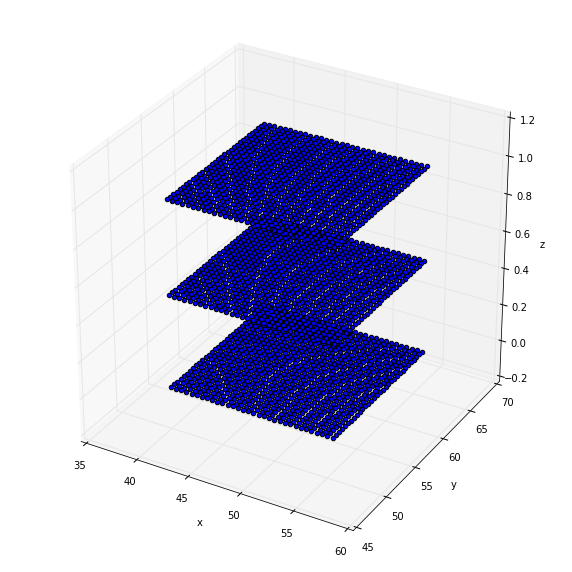

In [5]:
gcommands = convert_to_gcode(binarys, grid_unit=0.5, start_x=40, start_y=50)
write_gcode(gcommands, 'test.gcode')
graph(gcommands)